# KDE demo, with histosys!

> It works :)

![](assets/kde_pyhf_animation.gif)

In [3]:
#!pip install neos matplotlib celluloid
#!pip install git+http://github.com/scikit-hep/pyhf.git@diffable_json

In [4]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
import jax.scipy as jsp
import jax.numpy as jnp
import pyhf

pyhf.set_backend("jax")
pyhf.default_backend = pyhf.tensor.jax_backend(precision="64b")

from neos import data, makers
from relaxed import infer

rng = PRNGKey(22)

/workspaces/relaxed/.venv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)
# import jax.numpy as jnp
# def inv_sigmoid(x):
#     return jnp.log(x/(1-x))

## Compose differentiable workflow

In [6]:
dgen = data.generate_blobs(rng, blobs=4)

# Specify our hyperparameters ahead of time for the kde histograms
bins = np.linspace(0, 1, 4)
bins = jnp.array([-9999, *bins, 9999])
# bins = inv_sigmoid(obins)
bandwidth = 0.3
# bandwidth = inv_sigmoid(bandwidth)
reflect_infinite_bins = False
hmaker = makers.hists_from_nn(
    dgen,
    predict,
    hpar_dict=dict(bins=bins, bandwidth=bandwidth),
    method="kde",
    reflect_infinities=reflect_infinite_bins,
)

In [7]:
nnm = makers.histosys_model_from_hists(hmaker)
get_cls = infer.make_hypotest(
    nnm,
    solver_kwargs=dict(pdf_transform=False),
    metrics=["CLs", "pull", "pull_err", "errors"],
)

# loss returns a list of metrics -- let's just index into one (CLs)
def loss(params):
    return get_cls(params, test_mu=1.0)["CLs"]

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [8]:
# nnm(network)[0].config.suggested_init()
# get_cls(network, test_mu=1.0)["pull"][0]
bandwidth

0.3

In [9]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

# gradient wrt nn weights
jax.value_and_grad(loss)(network)

(DeviceArray(0.05989038, dtype=float64),
 [(DeviceArray([[-1.9226154e-05, -1.4563980e-04,  3.8508751e-04, ...,
                 -9.3753049e-05, -3.6742122e-04, -5.9716818e-05],
                [ 3.3096861e-05,  1.3640517e-04, -2.0504506e-04, ...,
                  6.4593360e-07,  2.6597574e-04,  1.2332791e-05]],            dtype=float32),
   DeviceArray([-3.4157893e-06,  9.8591390e-06,  2.3012605e-04, ...,
                 9.0226611e-05, -1.6447128e-04, -1.9854602e-05],            dtype=float32)),
  (),
  (DeviceArray([[ 2.03038326e-07,  4.89603735e-09,  1.01686128e-05, ...,
                  1.54051349e-09,  2.78494076e-06, -9.27906569e-08],
                [ 2.21226230e-07,  1.33390614e-07,  1.27345129e-05, ...,
                  1.15880052e-08,  3.83197857e-06, -1.05880838e-06],
                [-2.06168131e-08, -1.06322404e-05,  1.27415694e-06, ...,
                 -5.27743509e-07, -9.78128355e-06,  2.64568052e-06],
                ...,
                [ 4.07893680e-07,  2.9181462

### Define training loop!

In [10]:
opt_init, opt_update, opt_params = optimizers.adam(1e-3)


def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    np_errs = []
    mu_errs = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)

        metrs = get_cls(network, test_mu=1.0)
        mu_errs.append(metrs["errors"][0])
        np_errs.append(metrs["errors"][1])
        metrics = {
            "loss": losses,
            "pull": metrs["pull"],
            "pull_err": metrs["pull_err"],
            "np_err": np_errs,
            "mu_err": mu_errs,
        }

        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [21]:
def make_kde(data, bw):
    @jax.jit
    def get_kde(x):
        return jnp.mean(
            jsp.stats.norm.pdf(x, loc=data.reshape(-1, 1), scale=bw), axis=0
        )

    return get_kde


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(
                x + x_offset,
                y,
                width=bar_width * single_width,
                color=colors[i % len(colors)],
            )

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), fontsize="x-small")


def plot(axs, network, metrics, maxN, legend=False):
    ax = axs["Data space"]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins[1:-1]  # infinite
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = dgen()

    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0], bkg_up[:, 1], alpha=0.1, c="orangered", marker=6, label="bkg up"
    )
    ax.scatter(
        bkg_down[:, 0], bkg_down[:, 1], alpha=0.1, c="gold", marker=7, label="bkg down"
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if legend:
        ax.legend(fontsize="x-small", loc="upper right")
    ax = axs["CLs per epoch"]
    # ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="C9", linewidth=2.0, label=r"$CL_s$")
    ax.plot(
        metrics["np_err"],
        c="slategray",
        linewidth=2.0,
        label=r"$\sigma_{\mathsf{nuisance}}$",
    )
    ax.plot(metrics["mu_err"], c="steelblue", linewidth=2.0, label=r"$\sigma_\mu$")
    ax.set_yscale("log")
    # ax.set_ylim(1e-4, 0.06)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"metric value")
    if legend:
        ax.legend(fontsize="x-small", loc="upper right")

    ax = axs["Histogram model"]
    s, b, bup, bdown = hmaker(network)

    noinf = bins[1:-1]
    bin_width = 1 / (len(noinf) - 1)
    centers = noinf[:-1] + np.diff(noinf) / 2.0
    centers = jnp.array([noinf[0] - bin_width, *centers, noinf[-1] + bin_width])

    dct = {
        "signal": s,
        "bkg": b,
        "bkg up": bup,
        "bkg down": bdown,
    }

    bar_plot(
        ax,
        dct,
        colors=["C9", "C1", "orangered", "gold"],
        total_width=0.8,
        single_width=1,
        legend=legend,
    )

    # bunc = np.asarray([[x, y] if x > y else [y, x] for x, y in zip(bup, bdown)])
    # plot_unc = []
    # for unc, be in zip(bunc, b):
    #     if all(unc > be):
    #         plot_unc.append([max(unc), be])
    #     elif all(unc < be):
    #         plot_unc.append([be, min(unc)])
    #     else:
    #         plot_unc.append(unc)

    # plot_unc = np.asarray(plot_unc)
    # b_up, b_down = plot_unc[:, 0], plot_unc[:, 1]

    # ax.bar(centers, bup - b, bottom=b, alpha=0.4, color="red", width=bin_width, hatch="+", label="bkg_up")
    # ax.bar(
    #     centers, b - bdown, bottom=bdown, alpha=0.4, color="green", width=bin_width, hatch="-", label="bkg_down"
    # )

    # ax.set_ylim(0, 120)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

    ax = axs["Nuisance pull"]

    pulls = metrics["pull"]
    pullerr = metrics["pull_err"]

    ax.set_ylabel(r"$(\theta - \hat{\theta})\,/ \Delta \theta$", fontsize=18)

    # draw the +/- 2.0 horizontal lines
    ax.hlines([-2, 2], -0.5, len(pulls) - 0.5, colors="black", linestyles="dotted")
    # draw the +/- 1.0 horizontal lines
    ax.hlines([-1, 1], -0.5, len(pulls) - 0.5, colors="black", linestyles="dashdot")
    # draw the +/- 2.0 sigma band
    ax.fill_between([-0.5, len(pulls) - 0.5], [-2, -2], [2, 2], facecolor="yellow")
    # drawe the +/- 1.0 sigma band
    ax.fill_between([-0.5, len(pulls) - 0.5], [-1, -1], [1, 1], facecolor="green")
    # draw a horizontal line at pull=0.0
    ax.hlines([0], -0.5, len(pulls) - 0.5, colors="black", linestyles="dashed")

    ax.scatter(range(len(pulls)), pulls, color="black")
    # and their uncertainties
    ax.errorbar(
        range(len(pulls)),
        pulls,
        color="black",
        xerr=0,
        yerr=pullerr[0],
        marker=".",
        fmt="none",
    )

    ax = axs["Example KDE"]
    _, b_data, _, _ = dgen()
    d = np.array(predict(network, b_data).ravel().tolist())
    kde = make_kde(d, bandwidth)
    yields = b
    x = np.linspace(-1, 2, 300)
    db = jnp.array(jnp.diff(bins), float)  # bin spacing
    yields = yields / db / yields.sum(axis=0)  # normalize to bin width
    ax.stairs(yields, bins, label="KDE hist", color="C1")
    ax.plot(x, kde(x), label="KDE", color="C0")

    ax.set_xlim(-1, 2)

    # rug plot of the data
    ax.plot(
        d,
        jnp.zeros_like(d) - 0.01,
        "|",
        linewidth=3,
        alpha=0.4,
        color="black",
        label="data",
    )

    width = jnp.diff(bins[1:-1])[0]
    axins = ax.inset_axes([0.01, 0.79, 0.3, 0.2])
    xlim = (
        [(width / 2) - (1.1 * bandwidth), (width / 2) + (1.1 * bandwidth)]
        if (width / 2) - bandwidth < 0
        else [-width / 3, width + width / 3]
    )
    axins.stairs([1], [0, width], color="C1")
    y = jnp.linspace(xlim[0], xlim[1], 300)
    demo = jsp.stats.norm.pdf(y, loc=width / 2, scale=bandwidth)
    axins.plot(y, demo / max(demo), color="C0", linestyle="dashed", label="kernel")
    # draw two vertical lines at ((width/2)-bandwidth)/2 and ((width/2)+bandwidth)/2
    axins.vlines(
        [(width / 2) - bandwidth, (width / 2) + bandwidth],
        0,
        1,
        colors="black",
        linestyles="dotted",
        label=r"$\pm$bandwidth",
    )
    # write text in the middle of the vertical lines with the value of the bandwidth
    ratio = bandwidth / width
    axins.text(
        width / 2,
        -0.3,
        r"$\mathsf{\frac{bandwidth}{bin\,width}}=$" + f"{ratio:.2f}",
        ha="center",
        va="center",
        size="x-small",
    )

    axins.set_xlim(*xlim)
    axins.axis("off")
    handles, labels = ax.get_legend_handles_labels()
    handles1, labels1 = axins.get_legend_handles_labels()
    if legend:
        ax.legend(
            handles + handles1, labels + labels1, loc="upper right", fontsize="x-small"
        )

### Let's run it!!

epoch 0: pull=[-0.01205513]+-[[0.9325976]] CLs = 0.0599999337521524, took 1.996490240097046s


<ipython-input-21-a5b9359b4b33>:93: UserWarning: No contour levels were found within the data range.
  ax.contour(


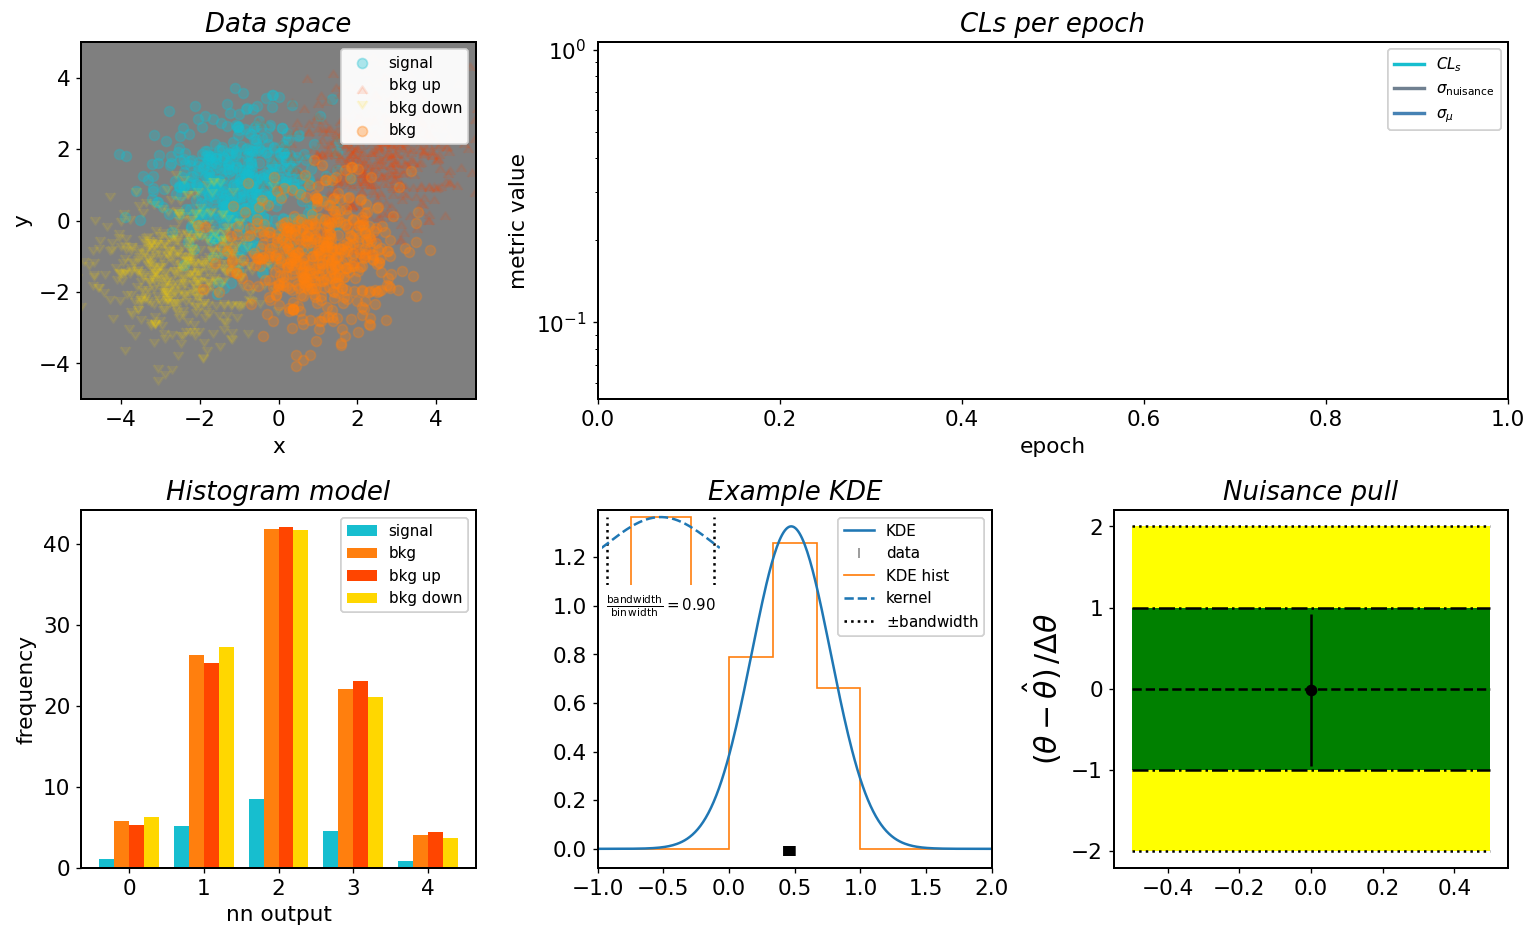

In [24]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.style.use("default")

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 8.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)

plt.rc("figure", dpi=120)

fig, axs = plt.subplot_mosaic(
    [
        ["Data space", "CLs per epoch", "CLs per epoch"],
        ["Histogram model", "Example KDE", "Nuisance pull"],
    ]
)

for label, ax in axs.items():
    ax.set_title(label, fontstyle="italic")

maxN = 1  # make me bigger for better results!

animate = True  # animations fail tests...
ax_cpy = axs
if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(
        f"epoch {i}:",
        f'pull={metrics["pull"]}+-{metrics["pull_err"]}',
        f'CLs = {metrics["loss"][-1]}, took {epoch_time}s',
    )
    if animate:
        if i == 0:
            plot(axs, network, metrics, maxN=maxN, legend=True)
        else:
            plot(axs, network, metrics, maxN=maxN)

        plt.tight_layout()
        camera.snap()
        axs = ax_cpy
        # if i % 10 == 0:
        #     camera.animate().save("animation.gif", writer="imagemagick", fps=8)
        # HTML(camera.animate().to_html5_video())
    # break

In [13]:
if animate:
    camera.animate().save("a2.gif", writer="imagemagick", fps=11)

In [14]:
if animate:
    camera.animate().save("a2.gif", writer="imagemagick", fps=10)

In [15]:
import jax
import jax.numpy as jnp


def inv_sigmoid(x):
    return jnp.log(x / (1 - x))


inv_sigmoid(jnp.linspace(0, 1, 4))

DeviceArray([       -inf, -0.69314718,  0.69314718,         inf], dtype=float64)

In [16]:
from IPython.display import HTML

animation = camera.animate()
HTML(animation.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [ ]:
camera.animate().save("/workspaces/relaxed/aregsoft.gif", writer="imagemagick", fps=10)